# Exploring dense convolution with Toeplitz transform

This notebook uses the fiber-tree emulator to display the behaviour of various 2-D+muliple output channel convolutions for dense data. Because the data is assumed to be dense we use the position-based operators on the premise that for dense data the position and coordinate are the same.

Note: The extension to multiple input channels should be straightforward, but would result in the Toeplitz tensor being rank-5, which is not displayable in the "uncompressed" form.

First, include some libraries

In [2]:
# Begin - startup boilerplate code

import pkgutil

if 'fibertree_bootstrap' not in [pkg.name for pkg in pkgutil.iter_modules()]:
  !python3 -m pip  install git+https://github.com/Fibertree-project/fibertree-bootstrap --quiet

# End - startup boilerplate code


from fibertree_bootstrap import *
fibertree_bootstrap(style="uncompressed", animation="movie")

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

In [3]:
enable_log = False

def set_params(log):
    global enable_log

    enable_log = (log == 'enable')

def log(*args):
    if enable_log:
        print(*args)

controls = interactive(set_params,
                       log=['disable', 'enable'])


display(controls)

interactive(children=(Dropdown(description='log', options=('disable', 'enable'), value='disable'), Output()), …

## Convolution Inputs Selection

Using sliders to select the shapes of the weights and input activations

In [5]:
H = 5
W = 5
R = 2
S = 2
K = 2


tm = TensorMaker("toeplitz")

tm.addTensor("I_HW",
             rank_ids=["H", "W"],
             shape=[H, W],
             density=1,
             interval=5,
             seed=0,
             color="blue")

tm.addTensor("F_KRS",
             rank_ids=["K", "R", "S"],
             shape=[K, R, S],
             density=1,
             interval=5,
             seed=0,
             color="green")

tm.displayControls()

interactive(children=(Label(value='Tensor Creation Controls', description='Title'), Label(value='Tensor I_HW',…

## Create Input Tensors

Given shapes selected above create and display the filter weights (**f**) and input activations (**i**) and a reference output (**o_verify**)

Input activations


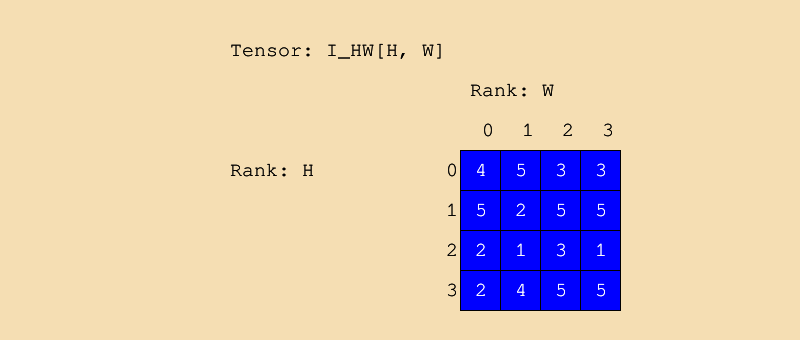

Filter weights


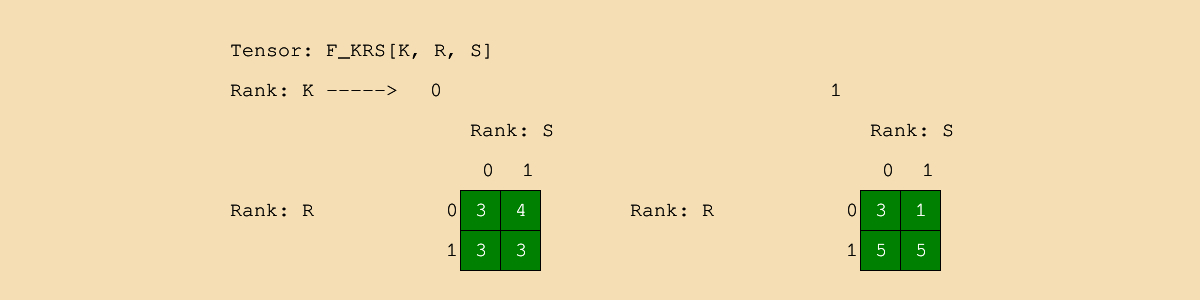


Output activations - 3x3


In [11]:
I_HW = tm.makeTensor("I_HW")
F_KRS = tm.makeTensor("F_KRS")

print("Input activations")
displayTensor(I_HW)
print("Filter weights")
displayTensor(F_KRS)

P = I_HW.getShape("H") - F_KRS.getShape("S") + 1
Q = I_HW.getShape("W") - F_KRS.getShape("R") + 1

print("")
print(f"Output activations - {P}x{Q}")


## Output Stationary

$$ O_{k,p,q} = I_{p+r, q+s} \times F_{k,r,s} $$

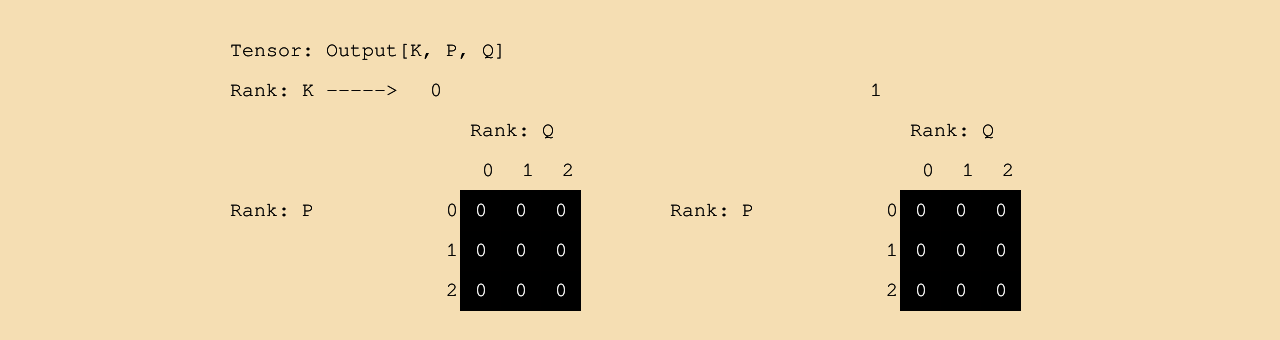

Convolution


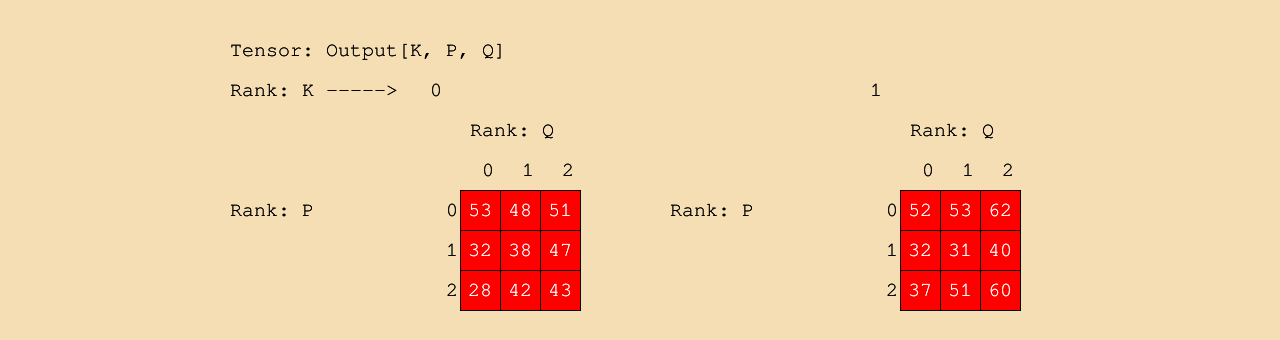

  0%|          | 0/74 [00:00<?, ?it/s]

In [19]:
o = Tensor(rank_ids=["K", "P", "Q"], shape=[K, P, Q]).setName("Output")

i = I_HW
f = F_KRS

# Hack to fill in all the entries in o
for k, o_p in o.getRoot().iterShapeRef():
    for p, o_q in o_p.iterShapeRef():
        for q, o_ref in o_q.iterShapeRef():
            pass
        
displayTensor(o)

print("Convolution")

output_shape = Fiber(coords=range(Q), initial=1)

canvas = createCanvas(i, f, o)

for k in range(K):
    for p in range(P):
        for q in range(Q):
            for r in range(R):
                for s in range(S):
                    h = p + r
                    w = q + s
                    o[k][p][q] += i[h][w] * f[k][r][s]

                    canvas.addActivity([(h,w) for h in range(p, p+S) for w in range(q, q+S)], (), worker="W")
                    canvas.addFrame((h,w), (k,r,s), (k,p,q))

displayTensor(o)
displayCanvas(canvas)

## Toplitz conversion

$$ T_{p,q,r,s} = I_{p+r, q+s} $$

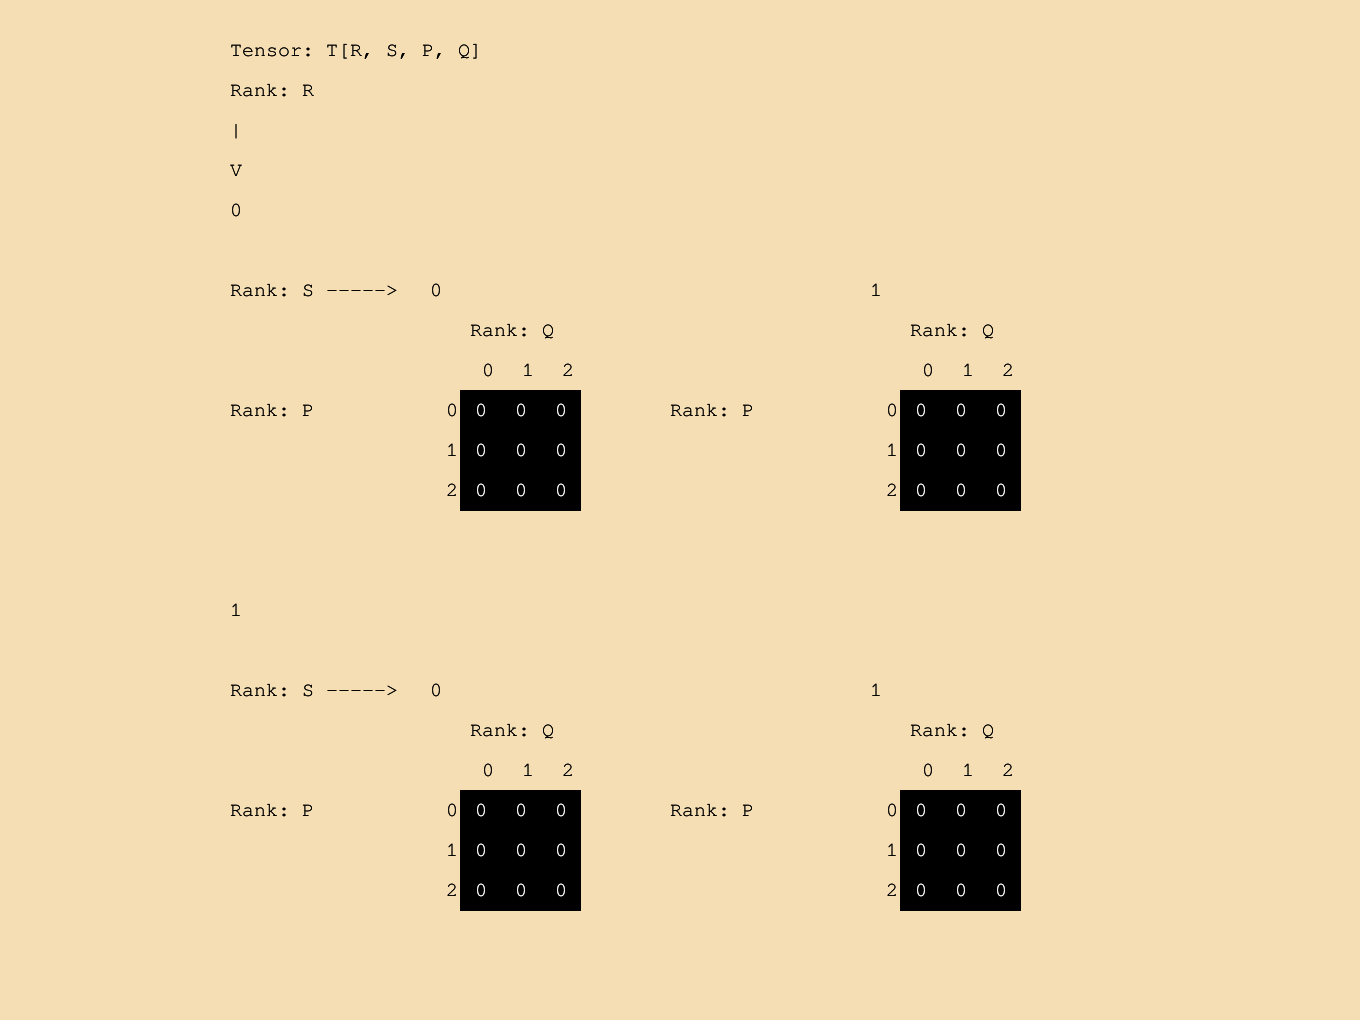

Toplitz matrix creation


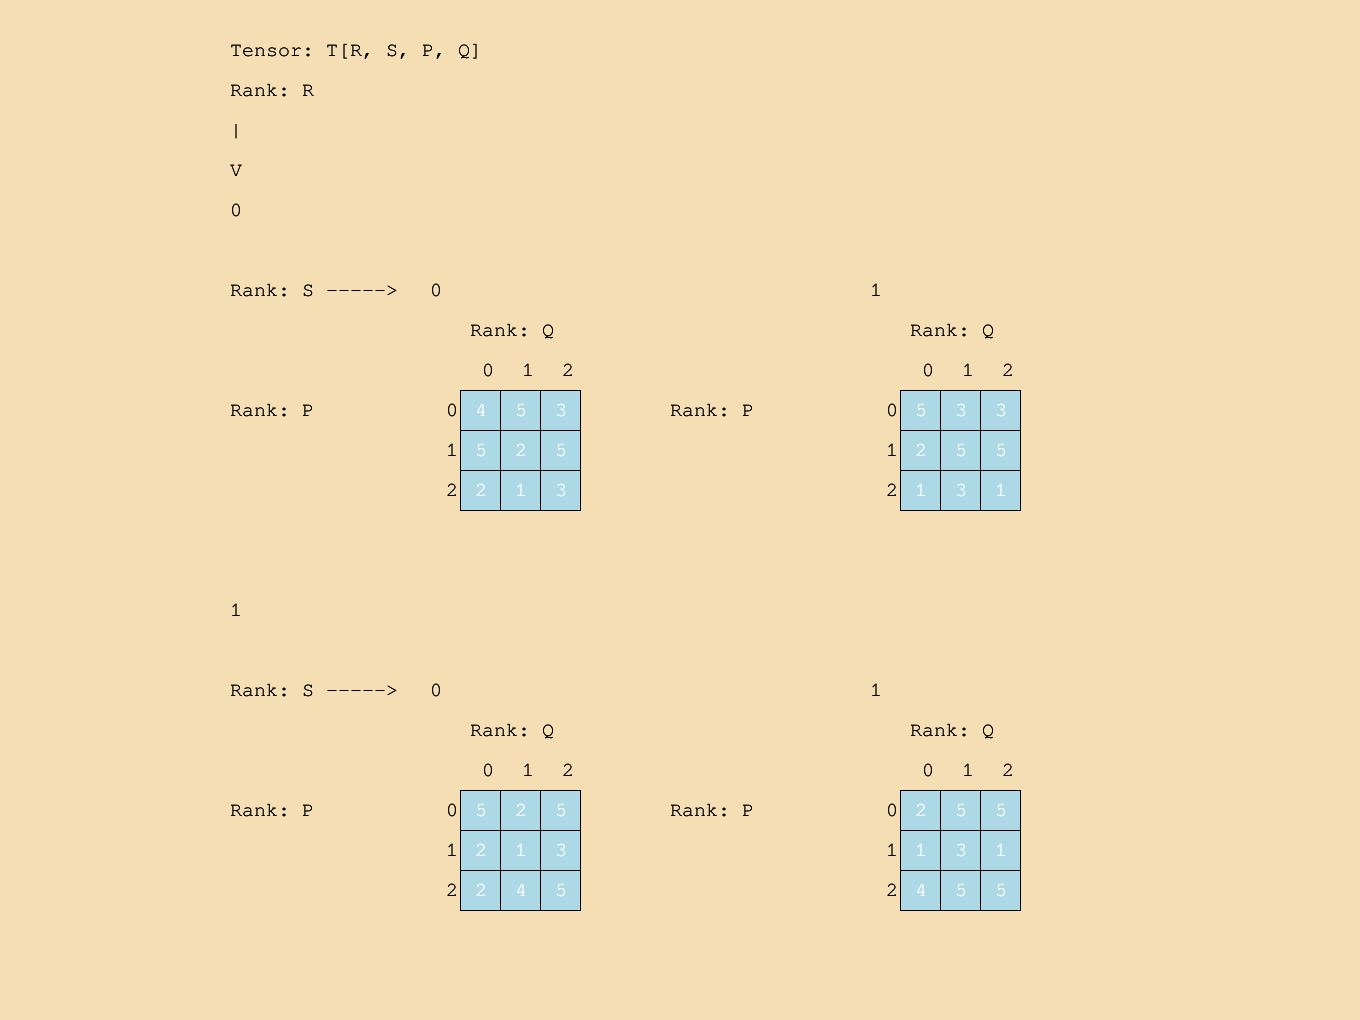

  0%|          | 0/38 [00:00<?, ?it/s]

In [20]:
t = Tensor(rank_ids=["R", "S", "P", "Q"], shape=[R, S, P, Q], name="T", color="lightblue")

# Hack to fill in all the entries in t

for r, t_s in t.getRoot().iterShapeRef():
    for s, t_p in t_s.iterShapeRef():
        for p, t_q in t_p.iterShapeRef():
            for q, t_ref in t_q.iterShapeRef():
                pass

print("Toplitz matrix creation")

canvas = createCanvas(i, t)

for p in range(P):
    for q in range(Q):
        for r in range(R):
            for s in range(S):
                t[r][s][p][q] <<= i[p+r][q+s]
                canvas.addFrame((p+r,q+s), (r,s,p,q))

displayTensor(t)
displayCanvas(canvas)


## Convolution (using Toeplitz matrix)

$$ O_{k,p,q} = T_{p,q,r,s} \times F_{k,r,s} $$

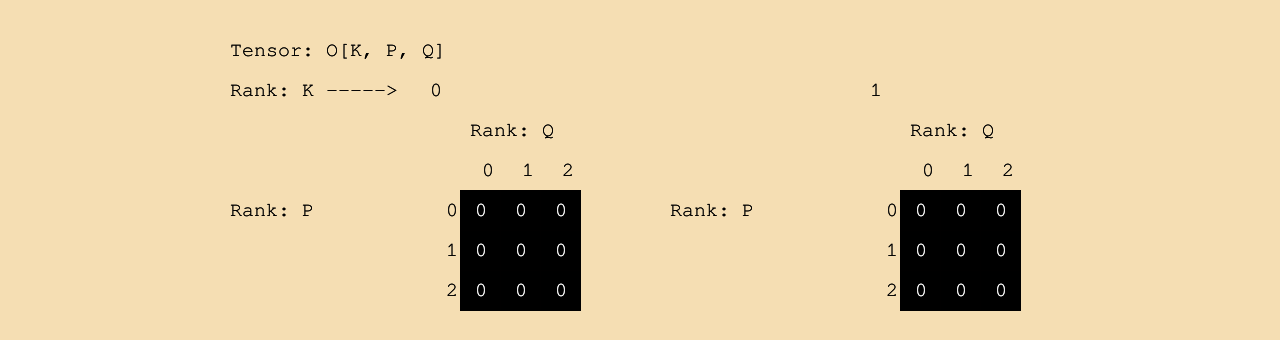

Toplitz-based convolution


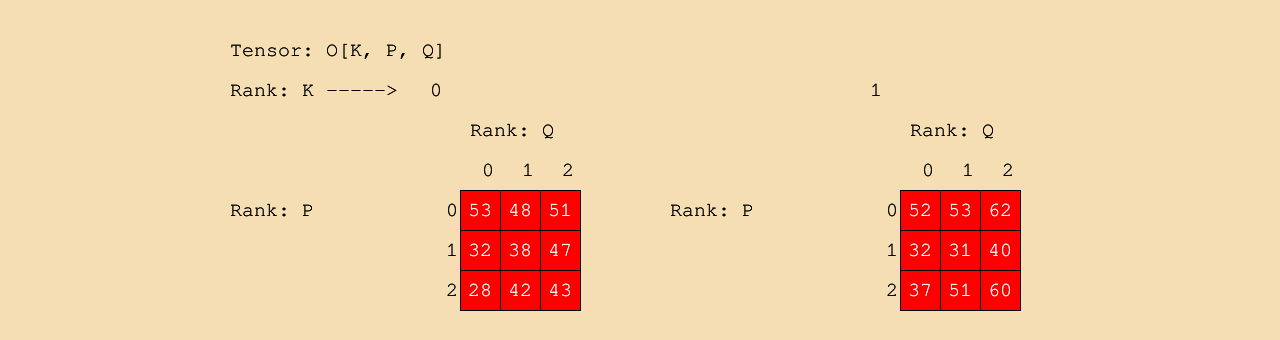

  0%|          | 0/74 [00:00<?, ?it/s]

In [23]:
o = Tensor(rank_ids=["K", "P", "Q"], shape=[K, P, Q], name="O")

# Hack to fill in all the entries in o

for k, o_p in o.getRoot().iterShapeRef():
    for p, o_q in o_p.iterShapeRef():
        for q, o_ref in o_q.iterShapeRef():
            pass
 
displayTensor(o)

print("Toplitz-based convolution")

canvas = createCanvas(t, f, o)

for k in range(K):
    for p in range(P):
        for q in range(Q):
            for r in range(R):
                for s in range(S):
                    o[k][p][q] += t[r][s][p][q] * f[k][r][s]
                    canvas.addFrame((r,s,p,q), (k,r,s), (k,p,q))

displayTensor(o)
displayCanvas(canvas)


## Flatten Filter Weights

$$F'_{k, r*S+s} = F_{k, r, s} $$

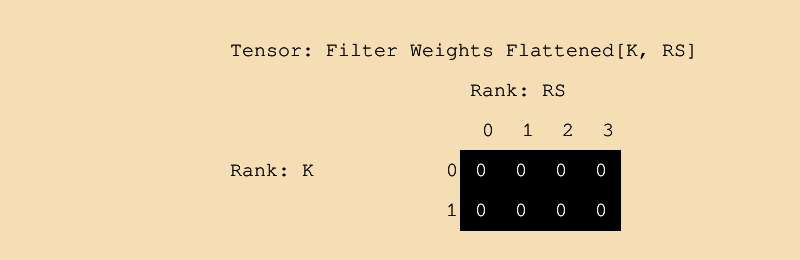

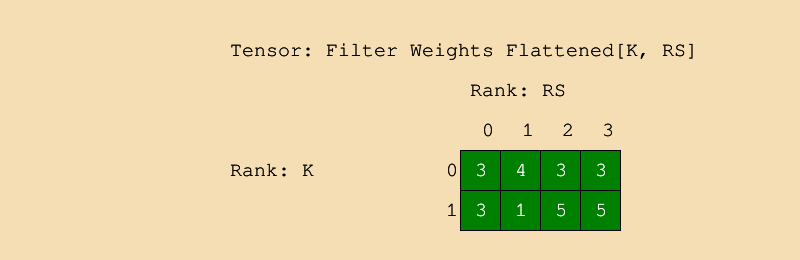

In [24]:
ff = Tensor(rank_ids=["K", "RS"], shape=[K, R*S], name="Filter Weights Flattened", color="green")

for k, ff_rs in ff.getRoot().iterShapeRef():
    for rs, ff_ref in ff_rs.iterShapeRef():
        pass
    
displayTensor(ff)

for k in range(K):
    for r in range(R):
        for s in range(S):
            rs = r*S + s
            ff[k][rs] <<= f[k][r][s]
            
displayTensor(ff)

## Flatten Toeplitz Tensor

$$ T'_{p \times Q + q, r \times S + s} = T_{p, q, r, s} $$

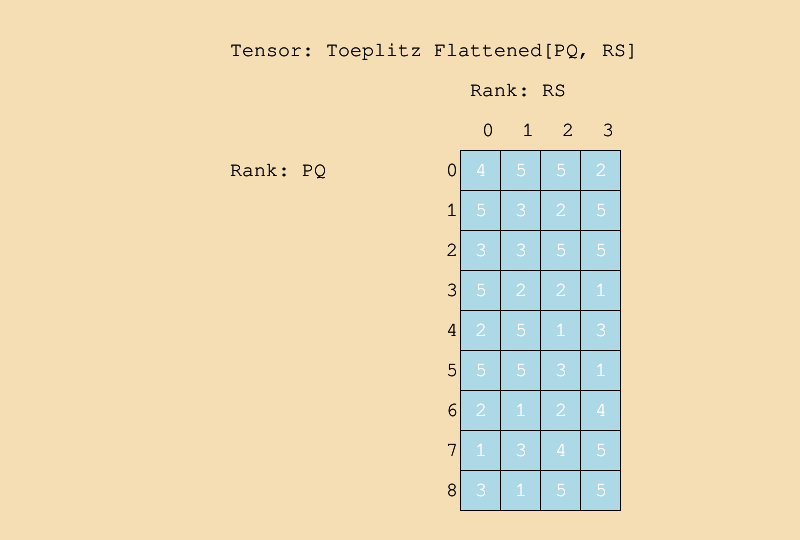

In [25]:
tf = Tensor(rank_ids=["PQ", "RS"], shape=[P*Q, R*S], name="Toeplitz Flattened", color="lightblue")

for k, tf_rs in tf.getRoot().iterShapeRef():
    for rs, tf_ref in tf_rs.iterShapeRef():
        pass

for p in range(P):
    for q in range(Q):
        pq = p*Q + q
        for r in range(R):
            for s in range(S):
                rs = r*S + s
                tf[pq][rs] <<= t[r][s][p][q]
            
displayTensor(tf)

## Flattened Convolution

$$ O'_{k,pq} = T'_{pq, rs} \times F'_{k, rs} $$

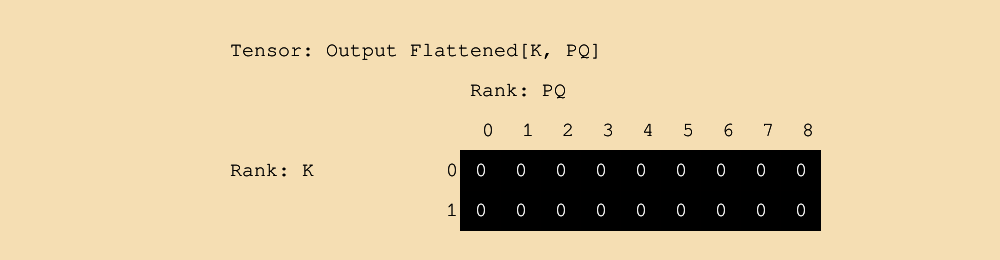

Flattened Toplitz-based convolution


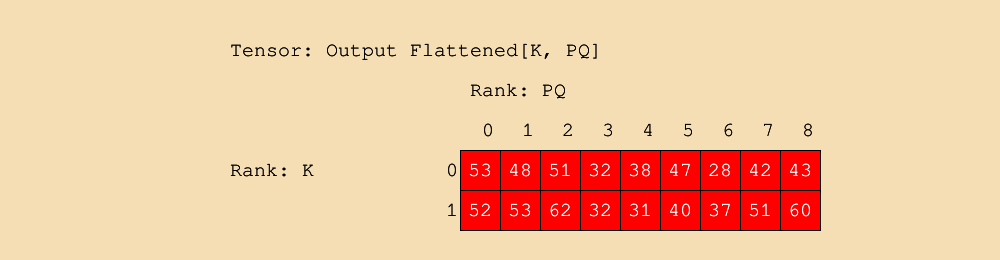

  0%|          | 0/74 [00:00<?, ?it/s]

In [28]:
of = Tensor(rank_ids=["K", "PQ"], shape=[K, P*Q], name="Output Flattened")


# Hack to fill in all the entries in o

for k, of_pq in of.getRoot().iterShapeRef():
    for pq, of_ref in of_pq.iterShapeRef():
            pass
 
displayTensor(of)

print("Flattened Toplitz-based convolution")

canvas = createCanvas(tf, ff, of)

for k in range(K):
    for pq in range(P*Q):
        for rs in range(R*S):
            of[k][pq] += tf[pq][rs] * ff[k][rs]
            canvas.addFrame((pq,rs), (k,rs), (k,pq))

displayTensor(of)
displayCanvas(canvas)


## Testing area

For running alternative algorithms